In [3]:
#Algorítimo de Árvores de decisão

In [4]:
# Importação das bibliotecas
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import matplotlib.pyplot as plt

import mlflow
import mlflow.sklearn

In [5]:
# Carregamento da base de dados e definição dos previsores (variáveis independentes - X) e classe (variável dependente - y)
zabbix = pd.read_csv('teste.csv',delimiter=";")
zabbix.shape

(632, 8)

In [6]:
# Mostra o tipo das variáveis
zabbix.dtypes

eventid                      int64
FROM_UNIXTIME(p.clock)      object
FROM_UNIXTIME(p.r_clock)    object
name                        object
name.1                      object
acknowledged                 int64
severity                     int64
esperado                     int64
dtype: object

In [7]:
# Retirando as informações da tabela
zabbix.drop('eventid', axis=1, inplace=True)
zabbix.drop('FROM_UNIXTIME(p.clock)', axis=1, inplace=True)
zabbix.drop('FROM_UNIXTIME(p.r_clock)', axis=1, inplace=True)
#zabbix.shape

In [8]:
zabbix.head()

,name,name.1,acknowledged,severity,esperado
0,CTA-DESENV has just been restarted,CTA-DESENV,0,3,3
1,Processor load is too high on CTA-DESENV,CTA-DESENV,0,2,2
2,Processor load is too high on CTA-DESENV,CTA-DESENV,0,2,2
3,Lack of free swap space on Icarai_ABC_coleta,Icarai_ABC_coleta,0,2,2
4,Unavailable by ICMP ping,BRT_SW_MADUREIRA_MANACEIA_2,0,4,3


In [9]:
# Conversão dos atributos categóricos para atributos numéricos
for col in zabbix.columns:
    if zabbix[col].dtype == 'object':
        zabbix[col] = zabbix[col].astype('category').cat.codes

In [10]:
zabbix.head()

,name,name.1,acknowledged,severity,esperado
0,23,33,0,3,3
1,60,33,0,2,2
2,60,33,0,2,2
3,45,57,0,2,2
4,67,17,0,4,3


In [11]:
previsores = zabbix.iloc[:,0:4].values
classe = zabbix.iloc[:,4].values

In [12]:
previsores

array([[ 23,  33,   0,   3],
       [ 60,  33,   0,   2],
       [ 60,  33,   0,   2],
       ...,
       [ 35,  50,   0,   1],
       [ 36,  99,   0,   2],
       [ 36, 100,   0,   2]], dtype=int64)

In [13]:
# Divisão da base de dados entre treinamento e teste. Usamos 30% para testar e 70% para treinar. Random_state = 0 para sempre obter a mesma divisão da base quando o código for executado
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(previsores,classe,
                                        test_size=0.5,random_state=0)

In [14]:
def treina_rf(n_estimators):
    mlflow.set_experiment("zbxexperimento")
    with mlflow.start_run():
        arvore = RandomForestClassifier(n_estimators=n_estimators)
        arvore.fit(X_treinamento, y_treinamento)
        previsoes = arvore.predict(X_teste) 

        #log de hiper parametros
        mlflow.log_param("n_estimators", n_estimators)    
    
        #métrica
        acuracia = accuracy_score(y_teste, previsoes)
    
        #registrar métrica
        mlflow.log_metric("acuracia",acuracia)
    
        #gráfico
        confusion = plot_confusion_matrix(arvore, X_teste, y_teste)
        plt.savefig("confusion.png")
    
        #logar gráfico
        mlflow.log_artifact("confusion.png")
    
        #modelo
        mlflow.sklearn.log_model(arvore,"ModeloZBX")
    
    
        #informações da execução
        print("Modelo: ", mlflow.active_run().info.run_uuid)    
    mlflow.end_run()

2021/05/28 22:58:11 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Modelo:  fabefe38a854467f9eb081f03d12e174
Modelo:  16c476b2a269444ba29bf7a3d430d7c7
Modelo:  21c98012a37e4990b776b3559bc29cc0
Modelo:  2bdd221833cb4989a2cfaa53199d1724
Modelo:  0a5f681950374a08bee4e49ef9827886
Modelo:  ac0700fe2cef46d4a8acd6548bb5fd5d
Modelo:  2c45670686464746a37583721ebaf324


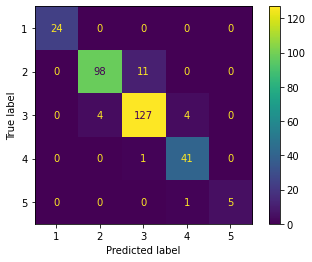

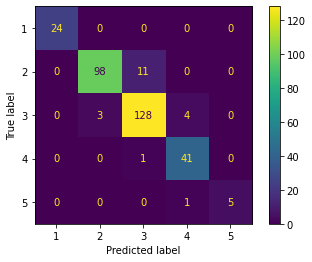

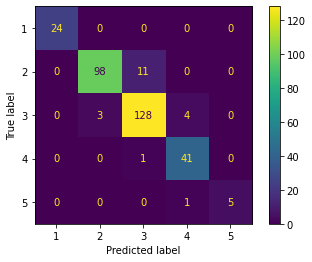

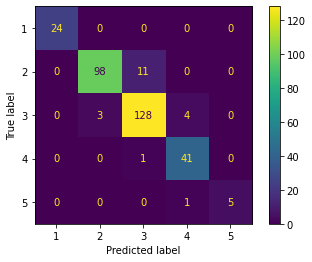

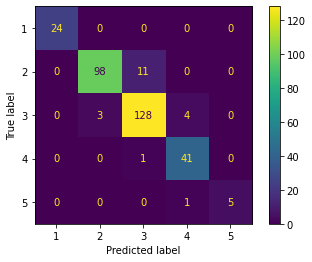

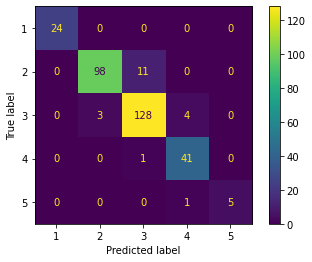

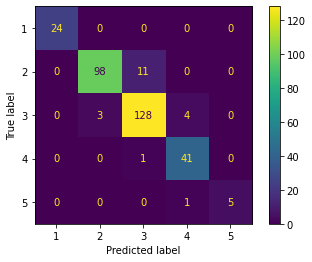

In [15]:
arvores = [20,80,600,4000,8000,50000,100000]
for n in arvores:
    treina_rf(n)

In [16]:
# Criação e treinamento do modelo
# Instânciando o objeto classificador:
#mlflow.set_experiment("teste_esperimento")
#with mlfow.start_run():
#    arvore = DecisionTreeClassifier(max_depth = None,
#                                 max_features = None,
#                                 criterion = 'entropy',
#                                 min_samples_leaf = 1,
#                                 min_samples_split = 2)
#    arvore.fit(X_treinamento, y_treinamento)
#mlflow.end_run()

In [15]:
#Verificando as features mais importantes para o modelo treinado:
#arvore.feature_importances_
#for feature,importancia in zip(zabbix.columns,arvore.feature_importances_):
#    print("{}:{}".format(feature, importancia))

In [16]:
# Exportação da árvore de decisão para o formato .dot, para posterior visualização
#export_graphviz(arvore, out_file = 'tree.dot')

In [17]:
# Obtenção das previsões
#previsoes = arvore.predict(X_teste)
#previsoes

In [18]:
# matriz de confusão
#confusao = confusion_matrix(y_teste, previsoes)
#confusao

In [19]:
#taxa acerto
#taxa_acerto = accuracy_score(y_teste, previsoes)
#taxa_acerto

In [20]:
#taxa erro
#taxa_erro = 1 - taxa_acerto
#taxa_erro